In [1]:
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

import json
import yaml
from underpinnings.OccupancyMap2 import OccupancyMap2




In [2]:
from gyrii.underpinnings.BayesianArray import BayesianArray
import numpy as np
from filterpy.common import kinematic_state_transition,Q_discrete_white_noise
from filterpy.kalman import predict, update

class KalmanPoseFilter:
    def __init__(self,x_unc,angle_unc,v_unc,vangle_unc):
        P=np.diag([x_unc**2,v_unc**2,x_unc**2,v_unc**2,angle_unc**2,vangle_unc**2])
        self.pose=BayesianArray(np.zeros(6),P)
        self.last_time_update=0
        self.q_variance=10.0 #TODO figure this out
        self.dt_threshhold=0.01

    def wrap_phase(self):
        self.pose.vals[2]=(self.pose.vals[2] + np.pi) % (2 * np.pi) - np.pi
    
    def predict_to_time(self,timestamp):        
        dt=timestamp-self.last_time_update        
        if dt<self.dt_threshhold:
            return #just don't bother for too short a time
        F=np.array([[1 ,dt,0 ,0 ,0 ,0],
                    [0 , 1,0 ,0 ,0 ,0],
                    [0 , 0,1 ,dt,0 ,0],
                    [0 , 0,0 , 1,0 ,0],
                    [0 , 0,0 , 0,1 ,dt],
                    [0 , 0,0 , 0,0 , 1]])        
        Q=Q_discrete_white_noise(dim=2,block_size=3,dt=dt,var=self.q_variance)
        self.pose.vals,self.pose.covariance = predict(self.pose.vals,self.pose.covariance,F,Q)
        self.wrap_phase()
        
        self.last_time_update=timestamp

    def update_with_position_measurement(self,timestamp,position): #bayesean array of first x,y
        self.predict_to_time(timestamp)
        z=position.vals
        R=position.covariance
        H=np.array([ [1,0,0,0,0,0],
                     [0,0,1,0,0,0]])
        self.pose.vals,self.pose.covariance = update(self.pose.vals,self.pose.covariance, z, R, H)
        
    def update_with_velocity_measurement(self,timestamp,velocity): #bayesian array of vx,vy
        self.predict_to_time(timestamp)
        z=velocity.vals
        R=velocity.covariance
        H=np.array([ [0,1,0,0,0,0],
                     [0,0,0,1,0,0]])
        self.pose.vals,self.pose.covariance = update(self.pose.vals,self.pose.covariance, z, R, H)
        
    def update_with_angle_measurement(self,timestamp,angle,angle_unc):
        self.predict_to_time(self,timestamp)
        if self.pose[2]-angle > np.pi:
            angle+=2*np.pi
        if self.pose[2]-angle < -np.pi:
            angle-=2*n.pi        
        z=np.array([angle])
        R=np.array([[angle_unc*angle_unc]])
        H=np.array([ [0,0,0,0,1,0]] )                     
        self.pose.vals,self.pose.covariance = update(self.pose.vals,self.pose.covariance, z, R, H)
        self.wrap_phase()
        

       

In [3]:
#test_pose=KalmanPoseFilter(1e-3,1e-3,1e-3,1e-3)
test_pose=KalmanPoseFilter(1,1,1,1)

zero_meas=BayesianArray(np.array([0,0]),np.eye(2))
intv=BayesianArray(np.array([0.2,0]),np.array([[0.1,0],[0,0.01]]))

times=[]
xval=[]
yval=[]
mxval=[]
myval=[]
dxval=[]
dyval=[]
for i in range(100):
    t=0.1*i
    mymeas=BayesianArray(zero_meas.random_sample(),zero_meas.covariance)
    mxval.append(mymeas.vals[0])
    myval.append(mymeas.vals[1])
    test_pose.update_with_position_measurement(t,mymeas)
    test_pose.update_with_velocity_measurement(t,BayesianArray(intv.random_sample(),intv.covariance))
    times.append(t)
    
    xval.append(test_pose.pose.vals[0])
    dxval.append(np.sqrt(test_pose.pose.covariance[0][0]))
    yval.append(test_pose.pose.vals[1])
    dyval.append(np.sqrt(test_pose.pose.covariance[1][1]))
    
    




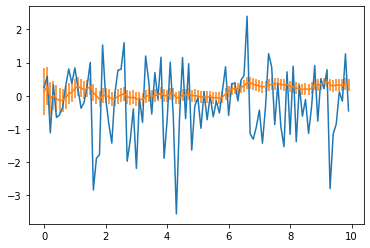

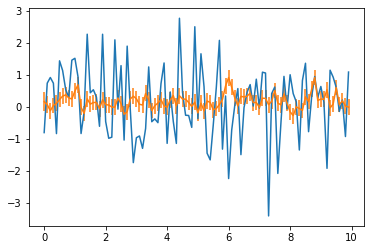

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(times,mxval)
#plt.plot(times,xval)
plt.errorbar(times,xval,yerr=dxval)
plt.show()
plt.figure()
plt.plot(times,myval)
plt.errorbar(times,yval,yerr=dyval)
plt.show()